# ĐỒ ÁN MẬT MÃ HỌC [NT219.N21.ANTN] 
Privacy-Preserving Credit Card Fraud Detection using Homomophic Encryption

    Thành viên:
1. Hà Thị Thu Hiền - 21522056
2. Phạm Ngọc Thơ - 21522641 


# 1. Training and Evaluation of Logistic Regression on Encrypted Data

## Setup

All modules are imported here. Make sure everything is installed by running the cell below:

In [1]:
!pip install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 52.9 MB/s eta 0:00:0000:0100:01


In [2]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [3]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
Y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 33.8 s, sys: 1.62 s, total: 35.4 s
Wall time: 45.8 s


## Normalize D Columns
The D Columns are "time deltas" from some point in the past. We will transform the D Columns into their point in the past. This will stop the D columns from increasing with time. The formula is D15n = Transaction_Day - D15 and Transaction_Day = TransactionDT/(24*60*60). Afterward we multiple this number by negative one.

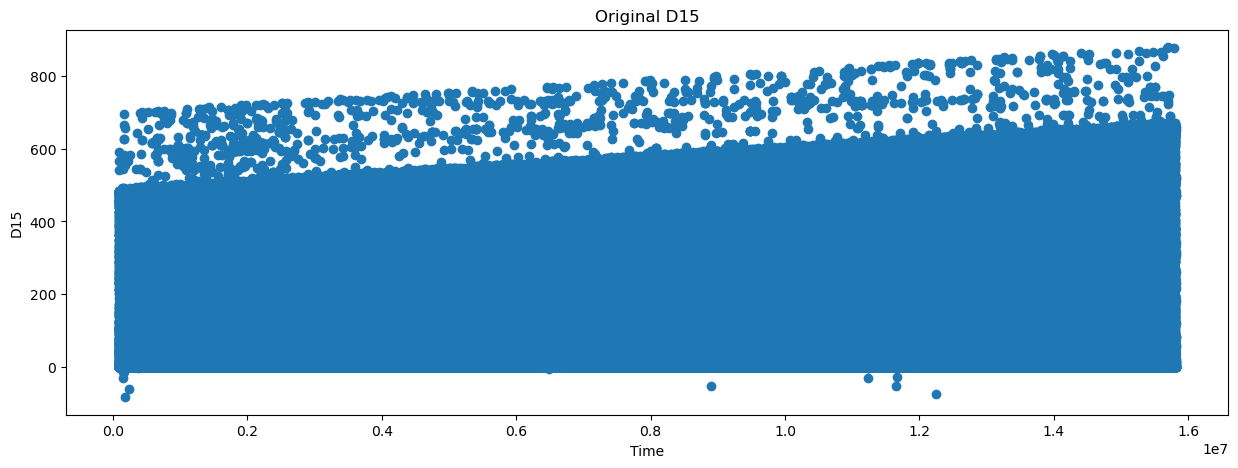

In [4]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [5]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

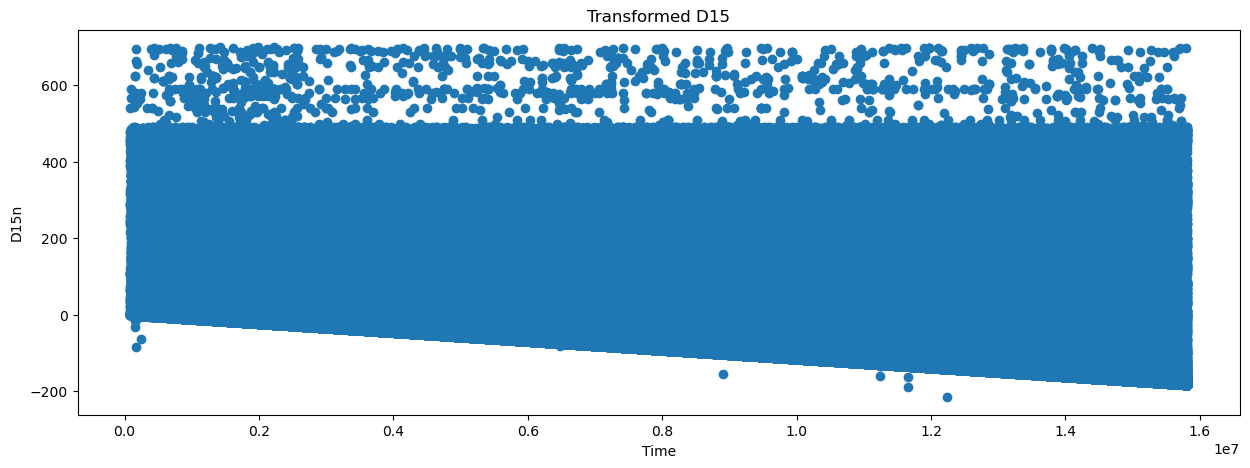

In [6]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [7]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

<timed exec>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type,

CPU times: user 9.25 s, sys: 5.51 s, total: 14.8 s
Wall time: 14.8 s


## Encoding Functions
Below are 5 encoding functions. (1) encode_FE does frequency encoding where it combines train and test first and then encodes. (2) encode_LE is a label encoded for categorical features (3) encode_AG makes aggregated features such as aggregated mean and std (4) encode_CB combines two columns (5) encode_AG2 makes aggregated features where it counts how many unique values of one feature is within a group. For more explanation about feature engineering, see the discussion here

In [8]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

## Feature Engineering
We will now engineer features. All of these features where chosen because each increases local validation. The procedure for engineering features is as follows. First you think of an idea and create a new feature. Then you add it to your model and evaluate whether local validation AUC increases or decreases. If AUC increases keep the feature, otherwise discard the feature.

In [9]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , 

<timed exec>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_28/2377275247.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
/tmp/ipykernel_28/2377275247.py:10: PerformanceWarning: DataFrame is high

card3_FE , P_emaildomain_FE , 

/tmp/ipykernel_28/2377275247.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
/tmp/ipykernel_28/2377275247.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1 , 

/tmp/ipykernel_28/2377275247.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
/tmp/ipykernel_28/2377275247.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1_P_emaildomain , card1_addr1_FE , 

/tmp/ipykernel_28/2377275247.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
/tmp/ipykernel_28/2377275247.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)
/tmp/ipykernel_28/2377275247.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1

card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 14 s, sys: 5.77 s, total: 19.7 s
Wall time: 19.8 s


## Feature Selection - Time Consistency
We added 28 new feature above. We have already removed 219 V Columns from correlation analysis done here. So we currently have 242 features now. We will now check each of our 242 for "time consistency". We will build 242 models. Each model will be trained on the first month of the training data and will only use one feature. We will then predict the last month of the training data. We want both training AUC and validation AUC to be above AUC = 0.5. It turns out that 19 features fail this test so we will remove them. Additionally we will remove 7 D columns that are mostly NAN. More techniques for feature selection are listed here

In [10]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
# for c in ['D6','D7','D8','D9','D12','D13','D14']:
#     cols.remove(c)
    
# # FAILED TIME CONSISTENCY TEST
# for c in ['C3','M5','id_08','id_33']:
#     cols.remove(c)
# for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
#     cols.remove(c)
# for c in ['id_'+str(x) for x in range(22,28)]:
#     cols.remove(c)

In [11]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 240 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5',
       'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1',
       'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
       'M7', 'M8', 'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13',
       'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37',
       'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62',
       'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86',
       'V88', 'V89', 'V91', 'V107', 'V108', 'V111', 'V115', 'V117',
       'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V136',
       'V138', 'V139', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165',
       'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180',
       'V182', 'V185',

## Local Validation
For this competition, we used time based local validation. I evaluated features by training on the first 75% of the data and predicting the last 25% of the data. Konstantin had a slightly different local validaiton. He trained on the first 4 months, skipped a month, and predicted the last month. Our current XGB model with 216 features achieves AUC = 0.9363 on Chris' local validation and AUC = 0.9241 on Konstantin's local validation. Note that this is the same AUC that Konstantin's LGBM achieves without magic that he posted here and here.

In [12]:
# CHRIS - TRAIN 75% PREDICT 25%
idxTrain = X_train.index[:19*len(X_train)//20]
idxTest = X_train.index[19*len(X_train)//20:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [13]:
x_train, y_train = X_train.loc[idxTrain,cols], Y_train[idxTrain]
x_test, y_test = X_train.loc[idxTest,cols], Y_train[idxTest]

## Training a Logistic Regression Model

In [14]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class LR(torch.nn.Module):
    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1) # output 1 value for binary classification
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x)) # sigmoid to get probabilities
        return out

In [16]:
from sklearn.utils.class_weight import compute_class_weight
n_features = x_train.shape[1]
model = LR(n_features)

# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)

# use Binary Cross Entropy Loss with weights
weights = compute_class_weight('balanced', classes=np.unique(y_train.values.ravel()), y=y_train.values.ravel())

# compute the average weight
average_weight = np.mean(weights)

weights = torch.tensor(average_weight, dtype=torch.float)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weights)


In [17]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
EPOCHS = 10
def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y.float())
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

def accuracy(model, x, y):
    out = model(x)
    predicted = (out > 0.5).float()
    correct = (predicted == y).float()
    return correct.mean()

def recall(model, x, y):
    out = model(x)
    predicted = (out > 0.5).float()
    recall = recall_score(y_true=y.numpy(), y_pred=predicted.detach().numpy())
    return recall

In [18]:
x_train = torch.tensor(x_train.values, dtype=torch.float)
y_train = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float)  # change here

# Convert pandas DataFrame or Series to numpy array before converting to PyTorch tensor
x_test = torch.tensor(x_test.values, dtype=torch.float)
y_test = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float)  # change here


In [19]:
print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([561013, 240])
y_train has shape: torch.Size([561013, 1])
x_test has shape: torch.Size([29527, 240])
y_test has shape: torch.Size([29527, 1])
#######################################


In [20]:
import numpy as np

# Determine the number of samples you want
num1_samples = x_train.shape[0] // 100
num2_samples = x_test.shape[0] // 100
# Generate a list of random indices
indices1 = np.random.choice(x_train.shape[0], size=num1_samples, replace=False)
indices2 = np.random.choice(x_test.shape[0], size=num2_samples, replace=False)

# Subset the data
x_train = x_train[indices1]
y_train = y_train[indices1]

x_test = x_test[indices2]
y_test = y_test[indices2]


print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([5610, 240])
y_train has shape: torch.Size([5610, 1])
x_test has shape: torch.Size([295, 240])
y_test has shape: torch.Size([295, 1])
#######################################


In [21]:
model = train(model, optim, criterion, x_train, y_train)

Loss at epoch 1: 0.861262321472168
Loss at epoch 2: 0.861262321472168
Loss at epoch 3: 0.861262321472168
Loss at epoch 4: 0.861262321472168
Loss at epoch 5: 0.861262321472168
Loss at epoch 6: 0.861262321472168
Loss at epoch 7: 0.861262321472168
Loss at epoch 8: 0.861262321472168
Loss at epoch 9: 0.861262321472168
Loss at epoch 10: 0.861262321472168


In [22]:
plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.9559321999549866


In [23]:
plain_recall = recall(model, x_test, y_test)
print(f"recall on plain test_set: {plain_recall}")

recall on plain test_set: 0.0


In [24]:
from joblib import dump
# save model
dump(model, '/kaggle/working/LR')

['/kaggle/working/LR']

In [25]:
import os

# Get file size
file_size = os.path.getsize('/kaggle/working/LR')

# Print file size
print(f"The size of the model BEFORE being encoded is {file_size} bytes")

# Convert size from bytes to kilobytes (KB) and megabytes (MB)
file_size_kb = file_size / 1024
file_size_mb = file_size_kb / 1024

print(f"The size of the model BEFORE being encoded is {file_size_kb} KB")
print(f"The size of the model BEFORE being encoded is {file_size_mb} MB")

The size of the model BEFORE being encoded is 2338 bytes
The size of the model BEFORE being encoded is 2.283203125 KB
The size of the model BEFORE being encoded is 0.0022296905517578125 MB


It is worth to remember that a high accuracy isn't our goal. We just want to see that training on encrypted data doesn't affect the final result, so we will be comparing accuracies over encrypted data against the plain_accuracy we got here.

## Encrypted Evaluation

In this part, we will just focus on evaluating the logistic regression model with plain parameters (optionally encrypted parameters) on the encrypted test set. We first create a PyTorch-like LR model that can evaluate encrypted data:

In [26]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        
    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        

eelr = EncryptedLR(model)

We now create a TenSEALContext for specifying the scheme and the parameters we are going to use. Here we choose small and secure parameters that allow us to make a single multiplication. That's enough for evaluating a logistic regression model, however, we will see that we need larger parameters when doing training on encrypted data.

In [27]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

We will encrypt the whole test set before the evaluation:

In [28]:
t_start = time()
enc_x_test = list(map(lambda x : ts.ckks_vector(ctx_eval, x.tolist()), x_test))
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 0 seconds


In [29]:
# (optional) encrypt the model's parameters
# eelr.encrypt(ctx_eval)

As you may have already noticed when we built the EncryptedLR class, we don't compute the sigmoid function on the encrypted output of the linear layer, simply because it's not needed, and computing sigmoid over encrypted data will increase the computation time and require larger encryption parameters. However, we will use sigmoid for the encrypted training part. We now proceed with the evaluation of the encrypted test set and compare the accuracy to the one on the plain test set.

In [30]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()
    
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        # encrypted evaluation
        enc_out = model(enc_x)
        # plain comparison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
    
    t_end = time()
    print(f"Evaluated test_set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)
    

encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...")

Evaluated test_set of 295 entries in 3 seconds
Accuracy: 282/295 = 0.9559322033898305
Difference between plain and encrypted accuracies: 0.0


We saw that evaluating on the encrypted test set doesn't affect the accuracy that much. I've even seen examples where the encrypted evaluation performs better.

## Training an Encrypted Logistic Regression Model on Encrypted Data

In this part we will redefine a PyTorch-like model that can both forward encrypted data, as well as backpropagate to update the weights and thus train the encrypted logistic regression model on encrypted data. Below are more details about the training.

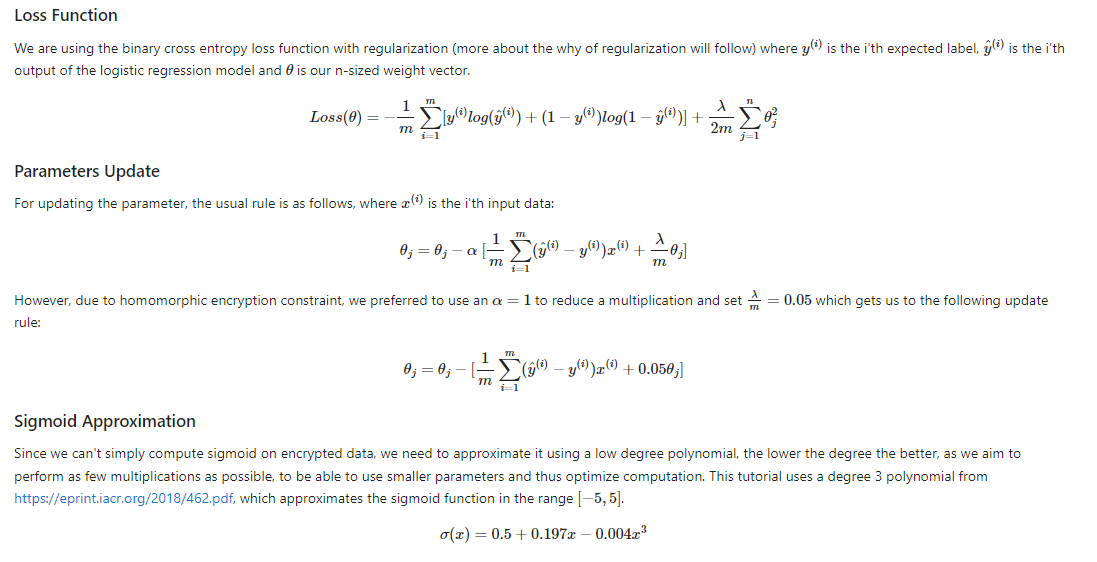

Từ dữ liệu đầu vào đến cập nhật tham số, bản mã sẽ cần độ sâu nhân là 6, 1 cho phép tính tích vô hướng, 2 cho phép xấp xỉ sigmoid và 3 cho giai đoạn lan truyền ngược (một thực sự được ẩn trong self._delta_w += enc_x * out_minus_y trong hàm quay ngược ()  **(a ciphertext will need a multiplicative depth of 6, 1 for the dot product operation, 2 for the sigmoid approximation, and 3 for the backpropagation phase (one is actually hidden in the self._delta_w += enc_x * out_minus_y operation in the backward() function )**, đang nhân một vectơ có kích thước 1 với một vectơ có kích thước n, yêu cầu che khe đầu tiên và sao chép nó n lần trong vectơ đầu tiên). Với thang đo khoảng 20 bit, chúng tôi cần mô đun 6 hệ số có cùng kích thước bit với thang đo, cộng với hệ số cuối cùng, cần nhiều bit hơn, chúng tôi đã ra khỏi mức độ mô đun đa thức 4096 (yêu cầu <109 tổng bit đếm của mô đun hệ số, nếu chúng ta xem xét bảo mật 128-bit), vì vậy chúng ta sẽ sử dụng 8192. Điều này sẽ cho phép chúng ta gộp tối đa 4096 giá trị trong một bản mã, nhưng chúng ta còn cách xa giới hạn này, vì vậy chúng ta không nên thậm chí nghĩ về nó.


In [31]:
#learning_rate = 0.01
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= (self._delta_w * (0.01 / self._count) + self.weight * 0.0005)#*learning_rate
        self.bias -= (self._delta_b * (0.01 / self._count))#*learning_rate
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
        #return enc_x.polyval([0.5, 0.25, 0, -0.021, 0, 0.002])

   
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def plain_recall(self, x_test, y_test):
        # evaluate recall of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        predicted = (out > 0.5).float()
        recall = recall_score(y_true=y_test.numpy(), y_pred=predicted.detach().numpy())
        return recall
    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [32]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40,21,21,21,21,21,21,40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [33]:
t_start = time()
enc_x_train = list(map(lambda x : ts.ckks_vector(ctx_training, x.tolist()), x_train))
enc_y_train = list(map(lambda y : ts.ckks_vector(ctx_training, y.tolist()), y_train))
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 113 seconds


In [35]:

eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)
    
    # if you want to keep an eye on the distribution to make sure
    # the function approximation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")
    recall = eelr.plain_recall(x_test, y_test)
    print(f"Recall at epoch #{epoch + 1} is {recall}")                   


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.345762699842453
Accuracy at epoch #1 is 0.09830508381128311
Recall at epoch #1 is 0.8
Accuracy at epoch #2 is 0.9661017060279846
Recall at epoch #2 is 0.0
Accuracy at epoch #3 is 0.033898305147886276
Recall at epoch #3 is 1.0
Accuracy at epoch #4 is 0.033898305147886276
Recall at epoch #4 is 1.0
Accuracy at epoch #5 is 0.9661017060279846
Recall at epoch #5 is 0.0
Accuracy at epoch #6 is 0.9661017060279846
Recall at epoch #6 is 0.0
Accuracy at epoch #7 is 0.9661017060279846
Recall at epoch #7 is 0.0
Accuracy at epoch #8 is 0.9661017060279846
Recall at epoch #8 is 0.0
Accuracy at epoch #9 is 0.9661017060279846
Recall at epoch #9 is 0.0
Accuracy at epoch #10 is 0.9661017060279846
Recall at epoch #10 is 0.0

Average time per epoch: 1571 seconds
Final accuracy is 0.9661017060279846
Difference between plain and encrypted accuracies: -0.010169506072998047
Oh! We got a better accuracy when training on encrypted data! The noise was on our side...


In [36]:
from joblib import dump
# save model
dump(eelr, '/kaggle/working/EncryptedLR')

['/kaggle/working/EncryptedLR']

In [37]:
import os

# Get file size
file_size = os.path.getsize('/kaggle/working/EncryptedLR')

# Print file size
print(f"The size of the model AFTER being encoded is {file_size} bytes")

# Convert size from bytes to kilobytes (KB) and megabytes (MB)
file_size_kb = file_size / 1024
file_size_mb = file_size_kb / 1024

print(f"The size of the model AFTER being encoded is {file_size_kb} KB")
print(f"The size of the model AFTER being encoded is {file_size_mb} MB")

The size of the model AFTER being encoded is 2276 bytes
The size of the model AFTER being encoded is 2.22265625 KB
The size of the model AFTER being encoded is 0.002170562744140625 MB


# Working with Approximate Numbers

## Setup

All modules are imported here. Make sure everything is installed by running the cell below.

In [38]:
import torch
from torchvision import transforms
from random import randint
import pickle
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from typing import Dict

import tenseal as ts

## TenSEAL CKKS Context

The first step is to create a CKKS TenSEAL context.

One potential example is

ctx = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
which specifies:

* scheme type: ts.SCHEME_TYPE.CKKS
* poly_modulus_degree: 8192.
* coeff_mod_bit_sizes: The coefficient modulus sizes, here [60, 40, 40, 60]. 
* This means that the coefficient modulus will contain 4 primes of 60 bits, 40 bits, 40 bits, and 60 bits.
* global_scale: the scaling factor, here set to 2^40.

optionally, TenSEAL supports switching between the public key and symmetric key encryption. By default, we will use public-key encryption.

By default, the relinearization keys are created, with automatic relinearization and rescaling enabled by default. The user can create the Galois keys by calling generate_galois_keys.

In [39]:
def context():
    context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.global_scale = pow(2, 40)
    context.generate_galois_keys()
    return context

context = context()

## Plain tensor creation

PlainTensor class works as a translation layer from common tensor representations to the encrypted forms offered by TenSEAL. It is the first step required for creating an encrypted tensor using TenSEAL.

Observation: This translation is also automatically done by the encrypted tensor constructors, and you can skip it.

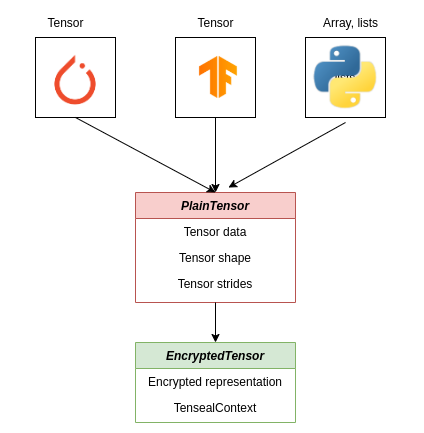

In [40]:
plain1 = ts.plain_tensor([1,2,3,4], [2,2])

print(" First tensor: Shape = {} Data = {}".format(plain1.shape, plain1.tolist()))

plain2 = ts.plain_tensor(np.array([5,6,7,8]).reshape(2,2))
print(" Second tensor: Shape = {} Data = {}".format(plain2.shape, plain2.tolist()))

 First tensor: Shape = [2, 2] Data = [[1.0, 2.0], [3.0, 4.0]]
 Second tensor: Shape = [2, 2] Data = [[5.0, 6.0], [7.0, 8.0]]


## Theory: Encrypted tensor creation
CKKS requires two operations for encrypting a new message:

## CKKS Encoding and Decoding
The operation encodes vectors of complex or real numbers into plaintext polynomials to be encrypted and computed using the CKKS scheme.

If the polynomial modulus degree is **N**
, then the encoding converts vectors of N/2 complex numbers into plaintext elements. Homomorphic operations performed on such encrypted vectors are applied coefficient (slot-)wise, enabling powerful SIMD functionality for computations that are vectorizable. (also known as batching)

The following diagram shows the detailed encoding-decoding flow(credits to Yongsoo Song, Introduction to CKKS, [Microsoft Private AI Bootcamp])

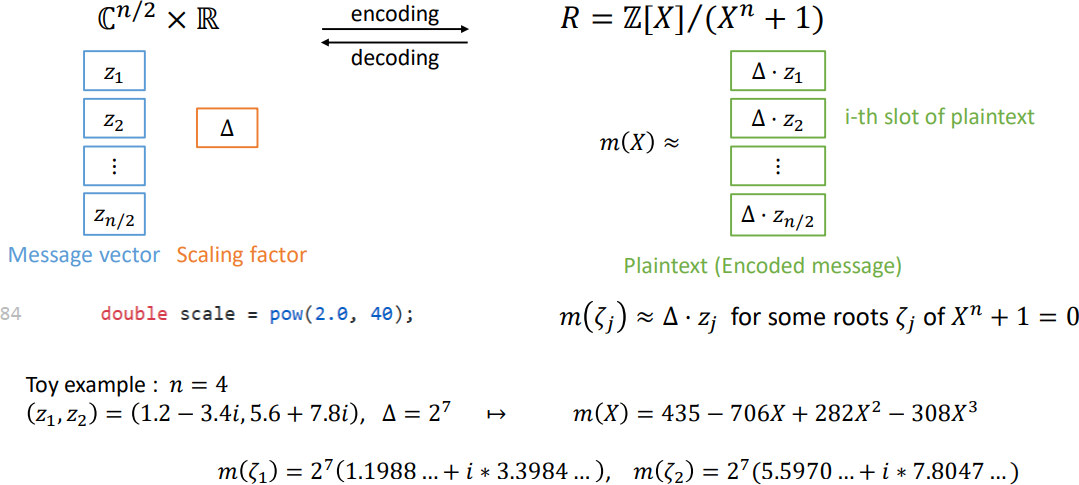

## CKKS Encryption and Decryption
This operation converts a plaintext polynomial to a ciphertext.

The following diagram shows the detailed encryption-decryption flow(credits to Yongsoo Song, Introduction to CKKS, [Microsoft Private AI Bootcamp]))

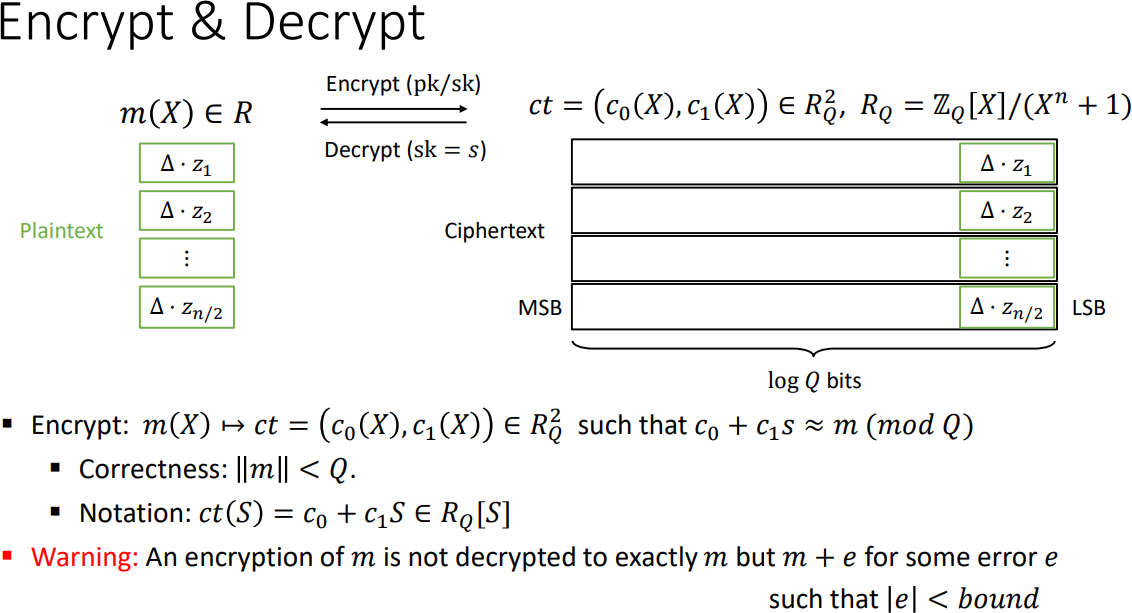

## Practice: Encrypted tensor creation
For creating a new encrypted tensor, TenSEAL executes the encoding and encryption automatically. This applies to both CKKS and BFV schemes.

The encrypted tensor encrypts a PlainTensor and stores the ciphertexts and shapes internally.

We have a few variants of encrypted tensors:

* **BFVVector** - for 1D integer arrays.
* **CKKSVector** - for 1D float arrays. This version has a smaller memory footprint, but it is less flexible.
* **CKKSTensor** - for N-dimensional float arrays. This version supports tensorial operations on encrypted data, like reshaping or broadcasting.
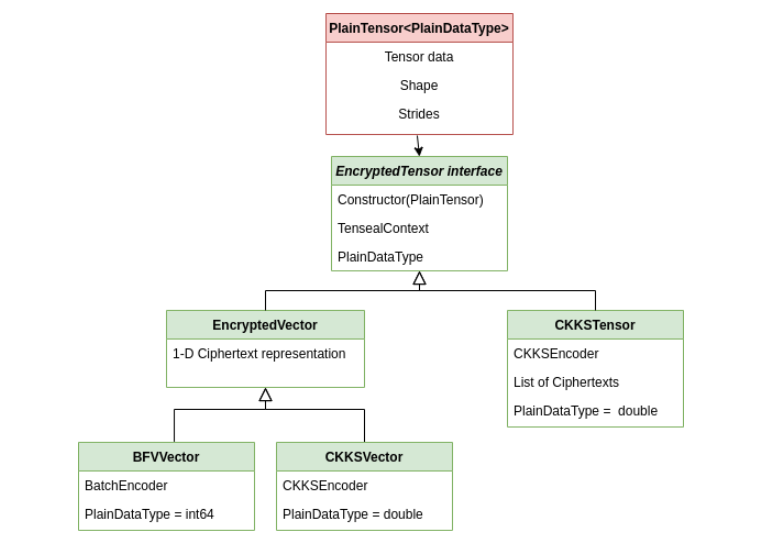

In [41]:
encrypted_tensor1 = ts.ckks_tensor(context, plain1)
encrypted_tensor2 = ts.ckks_tensor(context, plain2)

print(" Shape = {}".format(encrypted_tensor1.shape))
print(" Encrypted Data = {}.".format(encrypted_tensor1))


encrypted_tensor_from_np = ts.ckks_tensor(context, np.array([5,6,7,8]).reshape([2,2]))
print(" Shape = {}".format(encrypted_tensor_from_np.shape))
print(" Encrypted Data = {}.".format(encrypted_tensor_from_np))

 Shape = [2, 2]
 Encrypted Data = <tenseal.tensors.ckkstensor.CKKSTensor object at 0x7d3323f2e710>.
 Shape = [2, 2]
 Encrypted Data = <tenseal.tensors.ckkstensor.CKKSTensor object at 0x7d3323f2e740>.


## Basic operations
The following table enumerates the operations supported by CKKS tensors variants.

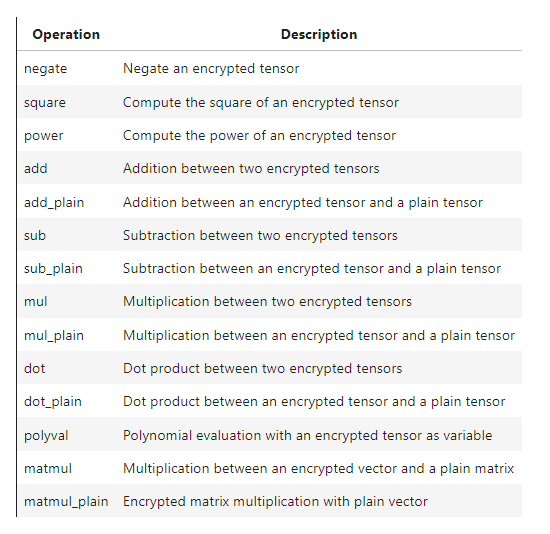

The CKKSVector variant contains the following additional operations:

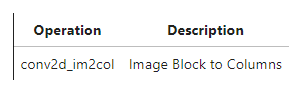

In [42]:
def decrypt(enc):
    return enc.decrypt().tolist()

## Addition of two encrypted tensors.

In [43]:
result = encrypted_tensor1 + encrypted_tensor2
print("Plain equivalent: {} + {}\nDecrypted result: {}.".format(plain1.tolist(), plain2.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] + [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[6.00000000017771, 8.000000000812912], [10.000000000415433, 11.999999999100112]].


## Subtraction of two encrypted tensors.

In [44]:
result = encrypted_tensor1 - encrypted_tensor2
print("Plain equivalent: {} - {}\nDecrypted result: {}.".format(plain1.tolist(), plain2.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] - [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[-3.999999999729111, -3.9999999996849964], [-4.00000000079947, -3.9999999999236002]].


## Multiplication of two encrypted tensors.
The following diagram shows the detailed flow for multiplication and relinearization (credits to Yongsoo Song, Introduction to CKKS, [Microsoft Private AI Bootcamp]))

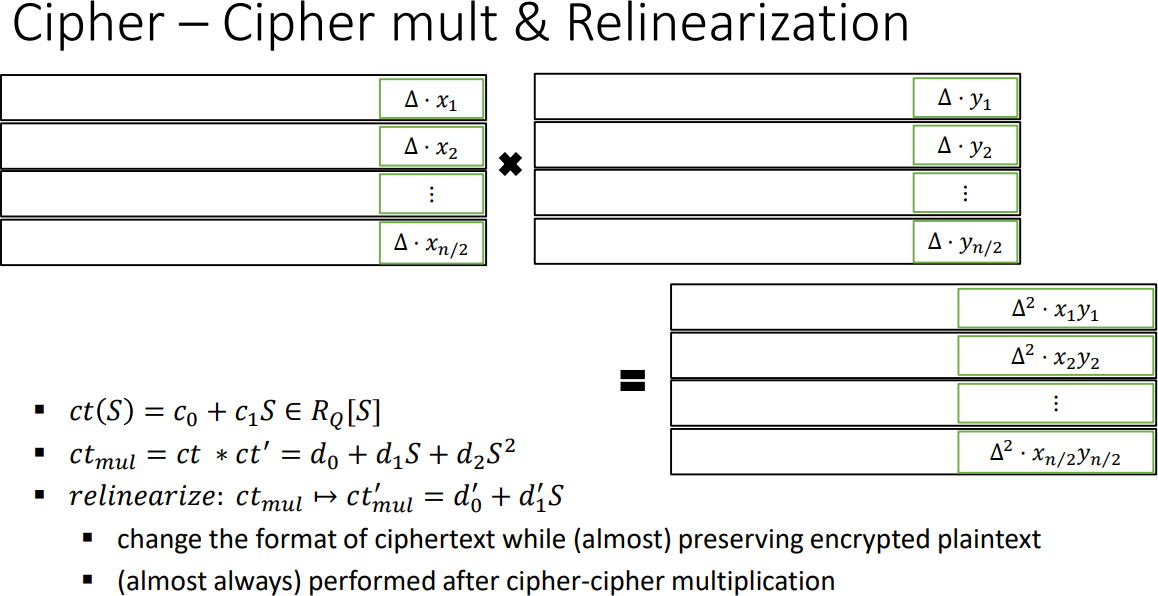


In [45]:
result = encrypted_tensor1 * encrypted_tensor2
print("Plain equivalent: {} * {}\nDecrypted result: {}.".format(plain1.tolist(), plain2.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] * [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[5.000000672246064, 12.000001613345281], [21.000002816922986, 32.00000428688822]].


## Multiplication with plain tensor

In [46]:
plain = ts.plain_tensor([5,6,7,8], [2,2])
result = encrypted_tensor1 * plain

print("Plain equivalent: {} * {}\nDecrypted result: {}.".format(plain1.tolist(), plain.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] * [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[5.000000672220361, 12.000001613117718], [21.000002814737133, 32.000004287779156]].


## Negation

In [47]:
result = -encrypted_tensor1 

print("Plain equivalent: -{}\nDecrypted result: {}.".format(plain1.tolist(), decrypt(result)))

Plain equivalent: -[[1.0, 2.0], [3.0, 4.0]]
Decrypted result: [[-1.0000000002243006, -2.0000000005639587], [-2.9999999998079825, -3.9999999995882574]].


## Power

In [48]:
result = encrypted_tensor1 ** 3
print("Plain equivalent: {} ^ 3\nDecrypted result: {}.".format(plain1.tolist(), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] ^ 3
Decrypted result: [[1.0000008035126637, 8.000006443541597], [27.00002172324672, 64.00005147785957]].


## Polynomial evaluation 1 + X^2 + X^3

In [ ]:
result = encrypted_tensor1.polyval([1,0,1,1])

print("X = {}".format(plain1.tolist()))
print("1 + X^2 + X^3 = {}.".format(decrypt(result)))

X = [[1.0, 2.0], [3.0, 4.0]]
1 + X^2 + X^3 = [[3.0000009368846343, 13.000006981620052], [37.000022929110614, 81.00005361976199]].


## Sigmoid approximation sig(x) = 0.5 + 0.2167 X

In [ ]:
result = encrypted_tensor1.polyval([0.5, 0.2167, 0])


print("X = {}".format(plain1.tolist()))
print("0.5 + 0.2167 X = {}.".format(decrypt(result)))

## Encrypted inference demo
Now that we introduced the CKKS scheme let's see it in action.

The next example contains a classification over the ***Credit Card Frauld dataset*** using a single convolution and two fully connected layers with a square activation function.

It illustrates one of the prominent use cases for homomorphic encryption, as depicted here.

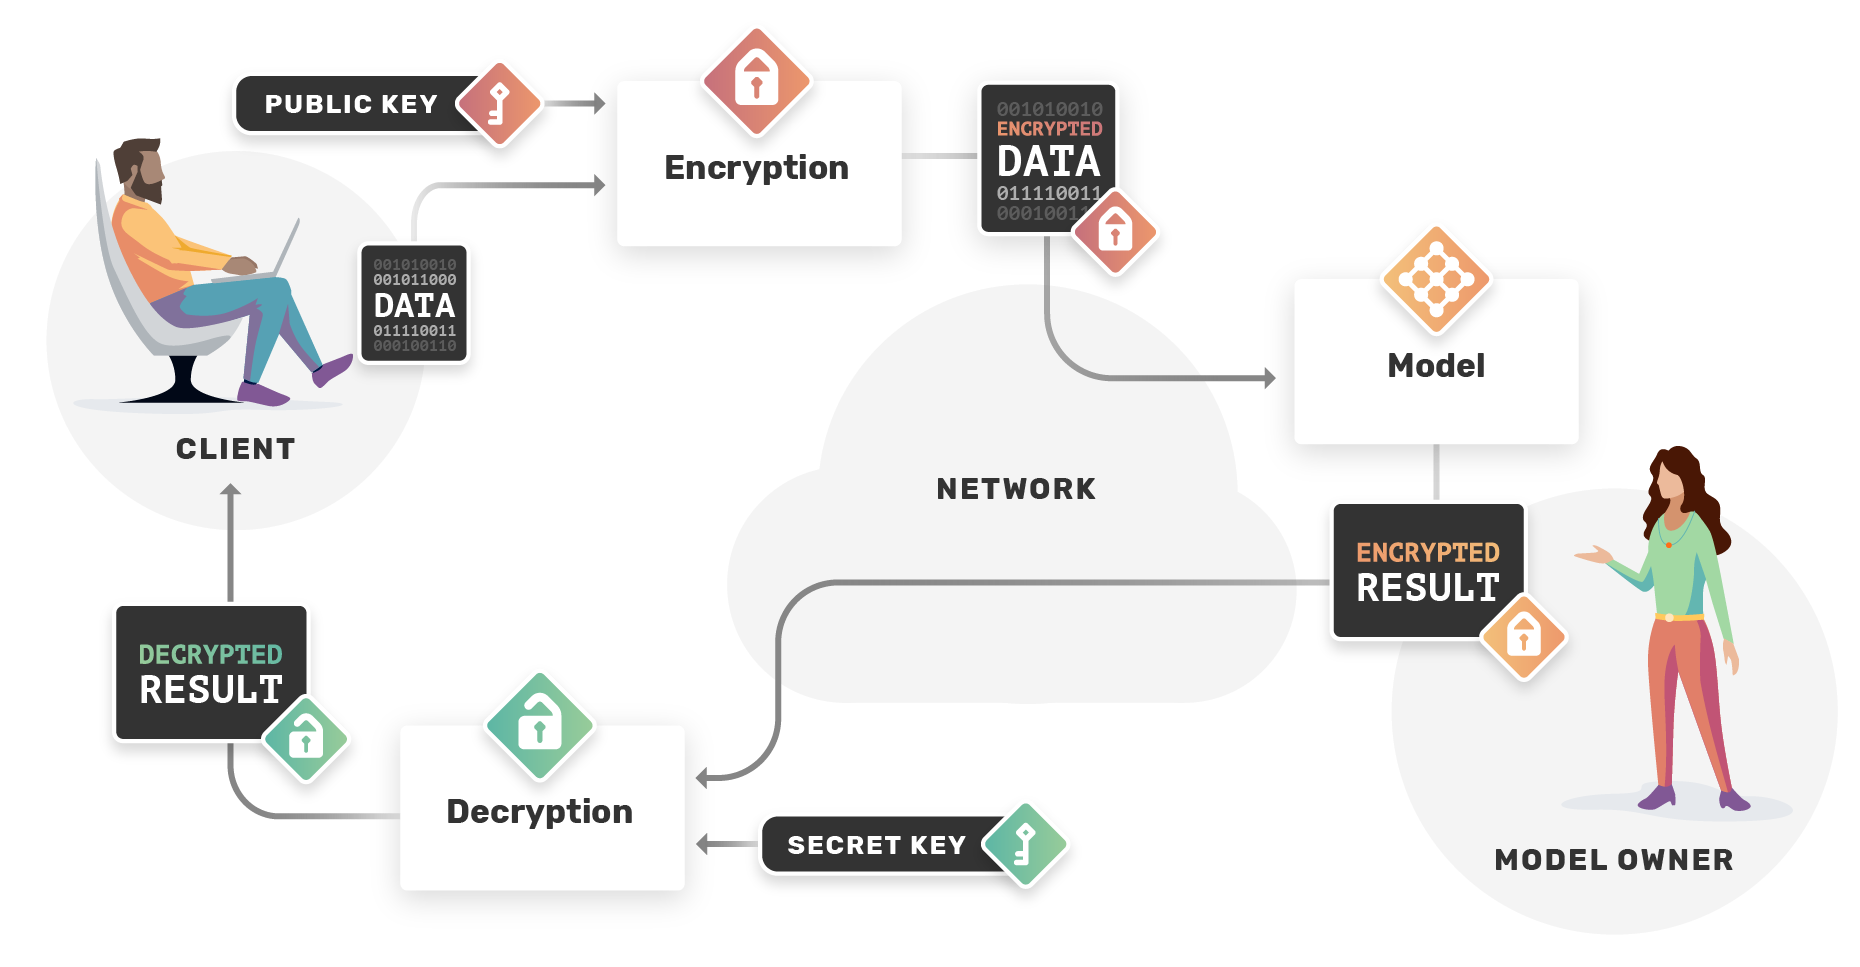
